In [26]:
from matplotlib.image import imread
from matplotlib import offsetbox
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import RandomizedPCA
from sklearn.metrics import pairwise_distances
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_mldata
from sklearn.manifold import Isomap
from sklearn.manifold import MDS

sns.set() 

## 5.10 流形学习
`PCA`是一个灵活、快速且容易解释的算法，但是它对存在非线性关系的数据集的处理效果并不太好，我们将在后面介绍几个示例。

为了弥补这个缺陷，我们选择另外一种方法--`流形学习`(manifold learning)。`流形学习`是一种无监督评估器，它试图将一个低维度流形嵌入到一个高维度空间来描述数据集。

当你思考`流形`时，设想有一张纸，一个存在于我们所熟悉的三维世界中的二维物体，它可以从两个维度弯折或卷起。提到流形学习这个术语时，可以把这张纸看成那个嵌入三维空间中二维流形。

在三维空间中旋转、重定向或者伸展这张纸，都不会改变它的平面几何特性。如果你弯折、卷曲或者弄皱这张纸，它仍然是一个二维流形，但是嵌入到一个三维空间就不再是线性的了。`流形学习`算法将试图学习这张纸的二维特征，包括将纸弯曲后放入一个三维空间中。

本节深入介绍几种流形方法的技巧，包括`多维标度法`(multidimensional scaling，MDS)、 `局部线性嵌入法`(locally linear embedding，LLE)和`保距映射法`(isometric mapping， Isomap)。

### 5.10.1 流形学习：`HELLO`
为了使这些概念更清楚，先生成一些二维数据来定义一个流形。我们创建一组数据，构成单词`HELLO`的形状：

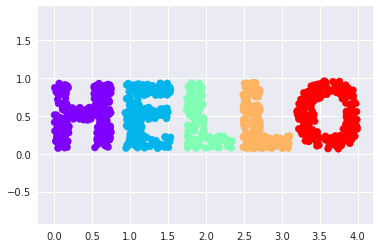

In [2]:
def make_hello(N=1000, rseed=42):
    # 画出“HELLO”文字形状的图像，并保存成PNG 
    fig, ax = plt.subplots(figsize=(4, 1)) 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1) 
    ax.axis('off') 
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85) 
    fig.savefig('hello.png') 
    plt.close(fig)

    # 打开这个PNG，并将一些随机点画进去 
    data = imread('hello.png')[::-1, :, 0].T 
    rng = np.random.RandomState(rseed) 
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T 
    mask = (data[i, j] < 1) 
    X = X[mask] 
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N] 
    return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5)) 
plt.scatter(X[:, 0], X[:, 1], **colorize) 
plt.axis('equal')
plt.show()

输出图像包含了很多二维的点，它们组成了`HELLO`的形状。这个数据形状可以帮助我们通过可视化的方式展现算法的使用过程。

### 5.10.2 多维标度法 (MDS)
观察这个数据集可以看到，数据集中选中的`x`值和`y`值并不是对数据的最基本描述：即使放大、缩小或旋转数据，`HELLO`仍然会很明显。例如，用一个旋转矩阵来旋转数据，`x`和`y`的值将会改变，但是数据形状基本还是一样的(`图5-95`)：

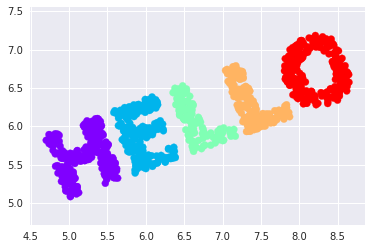

In [3]:
def rotate(X, angle):
    theta = np.deg2rad(angle) 
    R = [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]] 
    return np.dot(X, R)

X2 = rotate(X, 20) + 5 
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal')
plt.show()

例子中真正的基础特征是每个点与数据集中其他点的距离。表示这种关系的常用方法是`关系矩阵`：对于`N`个点，构建一个`N × N`的矩阵，元素`(i, j)`是点`i`和点`j`之间的距离。我们用`Scikit-Learn`中的`pairwise_distances`函数来计算原始数据的关系矩阵：

In [4]:
D = pairwise_distances(X) 
D.shape

(1000, 1000)

对于`1000`个点，获得了一个`1000×1000`的矩阵，如`图5-96`：

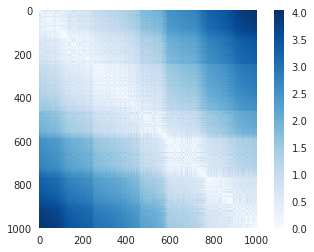

In [5]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest') 
plt.colorbar()
plt.show()

用类似方法为已经做过旋转和平移变换的数据构建一个距离矩阵，结果是非常接近的：

In [6]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

距离矩阵给出了一个数据集内部关系的表现形式，这种形式与数据集的旋转和投影无关。但距离矩阵的可视化效果却显得不够直观，`图5-96`丢失了我们之前在数据中看到的关于`HELLO`的所有视觉特征。

虽然从`(x, y)`坐标计算这个距离矩阵很简单，但是从距离矩阵转换回`x`坐标值和`y`坐标值却非常困难。这就是`多维标度法`可以解决的问题：它可以将一个数据集的距离矩阵还原成一个`D维坐标`来表示数据集。

下面来看看多维标度法是如何还原距离矩阵的。`MDS`模型将`非相似性`(dissimilarity)参数设置为`precomputed`来处理距离矩阵(`图5-97`)：

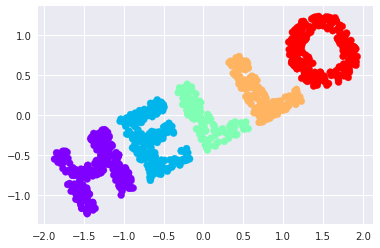

In [7]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1) 
out = model.fit_transform(D) 
plt.scatter(out[:, 0], out[:, 1], **colorize) 
plt.axis('equal')
plt.show()

**仅仅**依靠描述数据点间关系的`N × N`距离矩阵，`MDS`算法就可以为数据还原出一种可行的二维坐标。

### 5.10.3 将MDS用于流形学习
既然距离矩阵可以从数据的任意维度进行计算，那么这种方法绝对非常实用。既然可以在一个二维平面中简单地旋转数据，那么也可以用以下函数将其投影到三维空间(特别是用前面介绍过的`三维旋转矩阵`)：

In [8]:
def random_projection(X, dimension=3, rseed=42): 
    assert dimension >= X.shape[1] 
    rng = np.random.RandomState(rseed) 
    C = rng.randn(dimension, dimension) 
    e, V = np.linalg.eigh(np.dot(C, C.T)) 
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3) 
X3.shape

(1000, 3)

看看可视化效果(`图5-98`)：

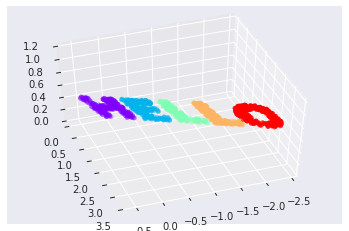

In [9]:
ax = plt.axes(projection='3d') 
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize) 
ax.view_init(azim=70, elev=50)
plt.show()

我们通过`MDS`评估器输入这个三维数据，计算距离矩阵，然后得出距离矩阵的最优二维嵌入结果，结果还原了原始数据的形状(`图5-99`)：

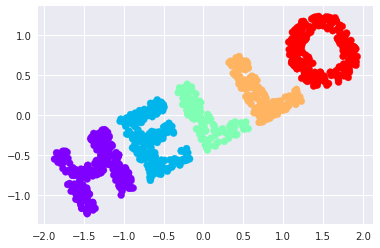

In [10]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3) 
plt.scatter(out3[:, 0], out3[:, 1], **colorize) 
plt.axis('equal')
plt.show()

以上就是使用`流形学习评估器`希望达成的基本目标：给定一个高维嵌入数据，寻找数据的一个低维表示，并保留数据间的特定关系。在`MDS`的示例中，保留的数据是每对数据点之间的距离。

### 5.10.4 非线性嵌入：当 MDS 失败时
前面介绍了线性嵌入模型，它包括将数据旋转、平移和缩放到一个高维空间的操作。但是当嵌入为非线性时，`MDS`就会失效。现在看看下面这个将输入数据在三维空间中扭曲成`S`形状的示例：

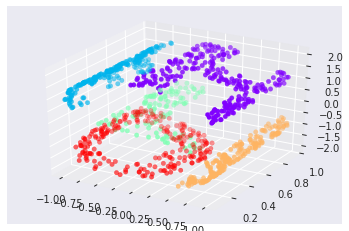

In [11]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi 
    x = np.sin(t) 
    y = X[:, 1] 
    z = np.sign(t) * (np.cos(t) - 1) 
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

ax = plt.axes(projection='3d') 
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)
plt.show()

虽然数据点间基本的关系仍然存在，但是这次数据以非线性的方式进行了变换：它被包裹成了`S`形。

如果尝试用`MDS`算法来处理这个数据，就无法展示数据非线性嵌入的特征，进而导致我们丢失了这个嵌入式流形的内部基本关系特性(`图5-101`)：

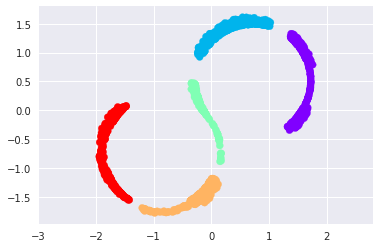

In [12]:
model = MDS(n_components=2, random_state=2) 
outS = model.fit_transform(XS) 
plt.scatter(outS[:, 0], outS[:, 1], **colorize) 
plt.axis('equal')
plt.show()

### 5.10.5 非线性流形：局部线性嵌入
该如何改进呢？先回顾一下问题的源头：`MDS`算法构建时总是期望保留相距很远的数据点之间的距离。如果修改算法，让它只保留比较接近的点之间的距离呢？嵌入的结果可能会与我们的期望更接近。

可以将这两种思路想象成`图5-102`所示的情况：
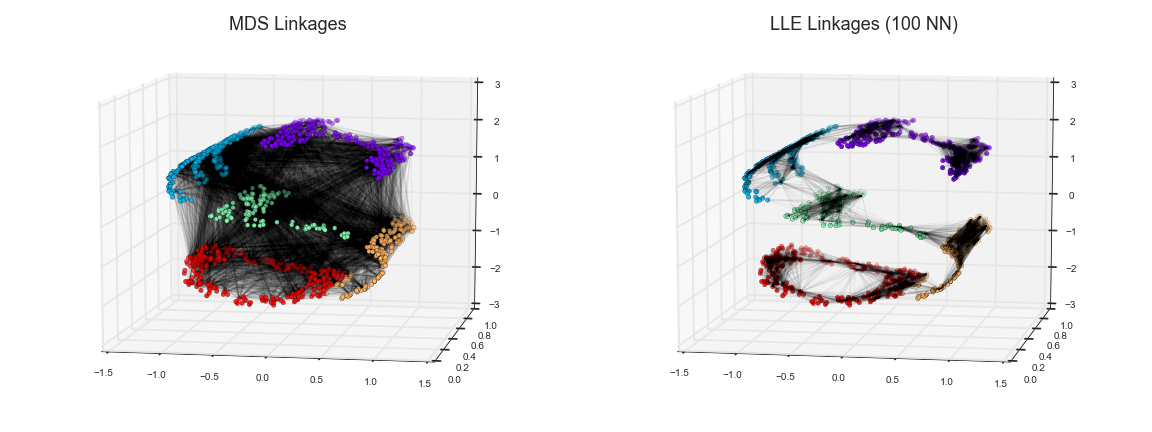

其中每一条细小的线都表示在嵌入时会保留的距离。左图是用`MDS`算法生成的嵌入模型，它会试图保留数据集中每对数据点间的距离；右图是用`局部线性嵌入`(LLE)生成的嵌入模型，它仅保留邻节点间的距离，本例选择与每个点最近的`100`个邻节点。

看看左图，就能够明白为什么`MDS`算法会失效了：不可能在展开数据的同时保证每条线段的长度完全不变。右图的情况则乐观一些。我们可以想象着通过某种方式将卷曲的数据展开，并且线段的长度基本保持不变。这就是`LLE`算法的工作原理，它通过对成本函数的全局优化来反映这个逻辑。

`LLE`有好几种表现形式，这里用`modiﬁed LLE`算法来还原嵌入的二维流形。通常情况下，`modiﬁed LLE`的效果比用其他算法还原实现定义好的流形数据的效果好，它几乎不会造成扭曲(`图5-103`)：

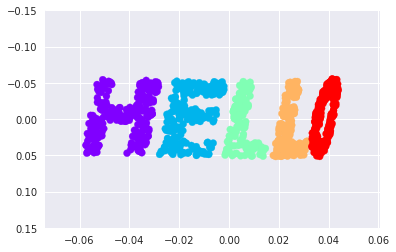

In [13]:
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense') 
out = model.fit_transform(XS)

fig, ax = plt.subplots() 
ax.scatter(out[:, 0], out[:, 1], **colorize) 
ax.set_ylim(0.15, -0.15)
plt.show()

比起原始流形，这个结果虽然出现了一定程度的扭曲，但还是保留了数据的基本关系特性。

### 5.10.6 关于流形方法的一些思考
由于流形学习在实际应用中的要求非常严格，因此除了在对高维数据进行简单的定性可视化之外，流形学习很少被正式使用。

以下是流形学习的一些特殊挑战，并将这些挑战与`PCA`算法进行了比较：
+ 在流形学习中，并没有好的框架来处理缺失值。相比之下，`PCA`算法中有一个用于处理缺失值的迭代方法
+ 在流形学习中，数据中噪音的出现将造成流形`短路`，并且严重影响嵌入结果。相比之下，`PCA`可以自然地从最重要的成分中滤除噪音
+ 流形嵌入的结果通常高度依赖于所选取的邻节点的个数，并且通常没有确定的定量方式来选择最优的邻节点个数。相比之下，`PCA`算法中并不存在这样的问题
+ 在流形学习中，全局最优的输出维度数很难确定。相比之下，`PCA`可以基于解释方差来确定输出的维度数
+ 在流形学习中，嵌入维度的含义并不总是很清楚；而在`PCA`算法中，主成分有非常明确的含义
+ 在流形学习中，流形方法的计算复杂度为$O[N^2]$或$O[N^3]$；而`PCA`可以选择随机方法，通常速度更快

以上列举的是流形学习相比于`PCA`算法的缺点，但是流形学习还有一个明显的优点，它具有保留数据中的非线性关系的能力。***正因为这个原因，通常的做法是：先用`PCA`探索数据的线性特征，再用流形方法探索数据的非线性特征***。

> 除了`Isomap`和`LLE`，`Scikit-Learn`还实现了其他几个常见的流形学习方法。
> `Scikit-Learn`文档有一篇非常精彩的[流形学习算法对比文章](http://scikit-learn.org/stable/modules/manifold.html)。

基于我的个人经验，给出以下几点建议：
+ `LLE`在`sklearn.manifold.LocallyLinearEmbedding`中实现。它对于简单问题，例如前面介绍过的S曲线、局部线性嵌入(LLE)及其变体(特别是modiﬁed LLE)的学习效果非常好
+ `Isomap`在`sklearn.manifold.Isomap`中实现。虽然`LLE`通常对现实世界的高维数据源的学习效果比较差，但是`Isomap`算法往往会获得比较好的嵌入效果
+ `t-分布邻域嵌入算法`(t-distributed stochastic neighbor embedding，t-SNE)在`sklearn. manifold.TSNE`中实现。将它用于高度聚类的数据效果比较好，但是该方法比其他方法学习速度慢

如果你对这些方法的工作方式感兴趣，那么我建议你用本节的数据运行这些方法，进而进行对比。

### 5.10.7 示例：用Isomap处理人脸数据
流形学习经常被用于探索高维数据点内部的关系。常见的高维数据示例就是图像数据。例如，一组`1000`像素的图像经常被看成是`1000`维度的点集合，每幅图像中每一个像素的亮度信息定义了相应维度上的坐标值。

我们用`Isomap`方法处理`Wild`数据集中带标签的人脸数据：

In [16]:
faces = fetch_lfw_people(min_faces_per_person=30) 
faces.data.shape

(2370, 2914)

我们有`2370`幅图像，每一幅图像有`2914`个像素，换句话说，这些图像可以被看成是一个`2914`维空间中的数据点的集合！

将几幅图像可视化(`图5-104`)：

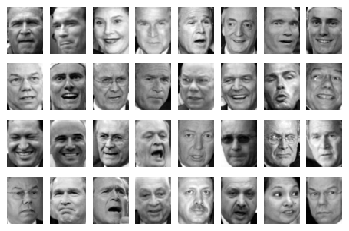

In [19]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[])) 
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')
plt.show()

我们希望画出这`2914`维数据的一个低维嵌入结果，以此来了解图像的基本关系。从计算`PCA`开始，从而查看解释方差的比率。通过这个比率，就可以判断需要多少线性特征才能描述数据(`图5-105`)：

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


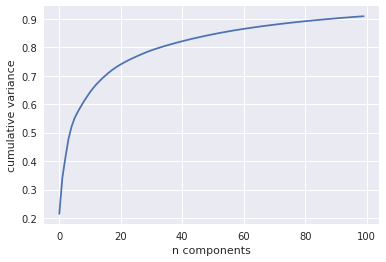

In [21]:
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.show()

大约需要`100`个成分才能保存`90%`的方差，说明该数据所需的维度非常高，仅通过几个线性成分无法描述。现在非线性流形嵌入方法，如`LLE`和`Isomap`就可以派上用场了：

In [23]:
model = Isomap(n_components=2) 
proj = model.fit_transform(faces.data) 
proj.shape

(2370, 2)

输出的是对所有图像的一个二维投影。为了更好地理解该投影表示的含义，来定义一个函数，在不同的投影位置输出图像的缩略图：

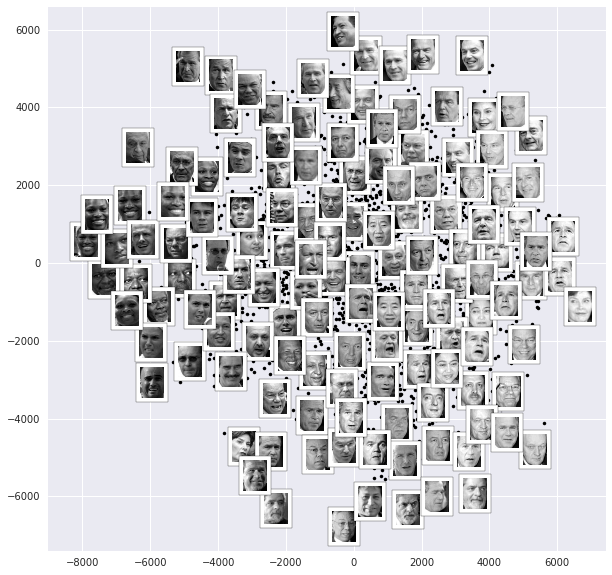

In [25]:
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data) 
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2 
        shown_images = np.array([2 * proj.max(0)])
        
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1) 
            if np.min(dist) < min_dist_2:
                # 不展示相距很近的点 
                continue
            shown_images = np.vstack([shown_images, proj[i]]) 
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), proj[i]) 
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=Isomap(n_components=2), images=faces.images[:, ::2, ::2])
plt.show()

结果非常有趣。前两个`Isomap`维度仿佛就描述了图像的整体特征：图像明暗度从左至右持续变化，人脸朝向从下到上持续变化。这是一组非常好的视觉指标，呈现了数据中一些基本特征。

我们可以根据这个结果将数据进行分类，用流形特征作为分类算法的输入数据。

### 5.10.8 示例：手写数字的可视化结构
另外一个使用流形学习进行可视化的例子，用到的是`MNIST手写数字数据集`。该数据和我们在`5.8`节中看到的数字类似，但是每幅图像包含的像素更多。它可以用`ScikitLearn`工具从`http://mldata.org/`下载(共`70000`幅图像，每幅图像`28*28=784像素`)：

In [27]:
mnist = fetch_mldata('MNIST original') 
mnist.data.shape

(70000, 784)

先看看前面几幅图像(`图5-107`)：

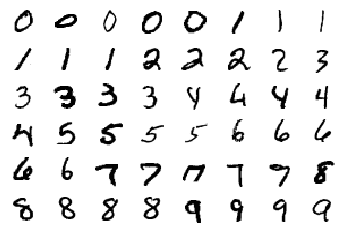

In [30]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[])) 
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')
plt.show()

下面来计算这些数据的流形学习投影(`图5-108`)。考虑到计算速度，我们仅使用数据集的`1/30`进行学习：

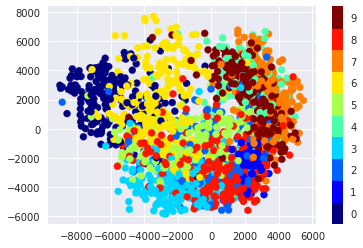

In [31]:
# 由于计算完整的数据集需要花很长时间，因此仅使用数据集的1/30 
data = mnist.data[::30] 
target = mnist.target[::30]

model = Isomap(n_components=2) 
proj = model.fit_transform(data) 
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10)) 
plt.colorbar(ticks=range(10)) 
plt.clim(-0.5, 9.5)
plt.show()

该散点图结果展示了数据点间的一些关系，但是点的分布有一点拥挤。我们可以一次只查看一个数字(`图5-109`)：

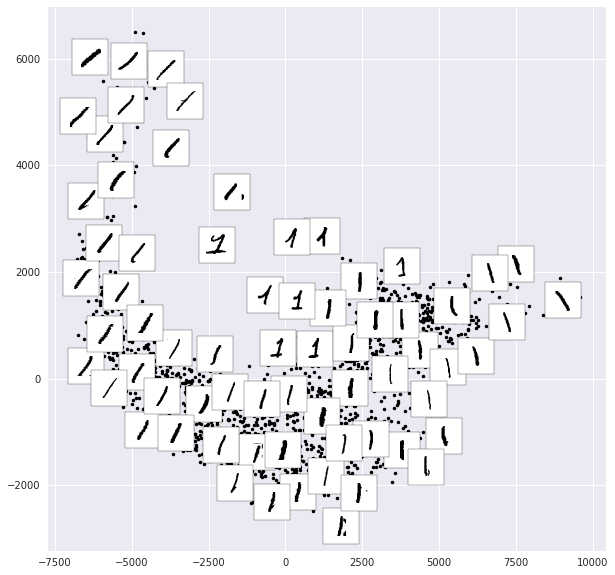

In [32]:
# 选择1/4的数字"1"来投影 
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10)) 
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense') 
plot_components(data, model, images=data.reshape((-1, 28, 28)), ax=ax, 
                thumb_frac=0.05, cmap='gray_r')
plt.show()

结果表明，数据集中数字`1`的形式是多种多样的。这个数据在投影空间中分布在一个较宽的曲面上，都像是沿着数字的方向。当你沿着图像向上看，将发现一些带着`帽子`且/或带有`底座`的数字`1`，虽然这些形式在整个数据集中非常少。可见，流形投影可以让我们发现数据中的异常点(即邻近的数字片段被偷偷放入抽取的图像中)。

虽然这种方法可能对数字分类任务并没有帮助，但是它确实可以帮助我们更好地理解数据，并且能提供一些进一步分析数据的线索。例如，在构建分类管道模型之前，该如何对数据进行预处理。